# Blackbox End-to-End Model

Fair comparison to CBM:
- Same dataset (150 labeled windows)
- Same 6 classes
- Same train/test split
- Direct activity prediction (no concepts)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.11.3


In [6]:
# Load data
df_sensor = pd.read_csv('../data/final_dataset.csv')
df_windows = pd.read_csv('../data/final_window_labels.csv')

# Create activity mapping
activity_mapping = {act: i for i, act in enumerate(np.unique(df_windows["activity"].values))}
reverse_activity_mapping = {v: k for k, v in activity_mapping.items()}

print(f"Sensor data: {len(df_sensor)} readings")
print(f"Labeled windows: {len(df_windows)} windows")
print(f"Activities: {list(activity_mapping.keys())}")
print(f"\nActivity distribution:")
print(df_windows['activity'].value_counts())

Sensor data: 8802 readings
Labeled windows: 150 windows
Activities: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

Activity distribution:
activity
Walking       27
Jogging       26
Standing      25
Sitting       24
Upstairs      24
Downstairs    24
Name: count, dtype: int64


In [7]:
# Same split as CBM (stratified by activity)
train_idx, test_idx = train_test_split(
    df_windows.index, test_size=0.25, random_state=42, stratify=df_windows['activity']
)

df_windows_train = df_windows.loc[train_idx].reset_index(drop=True)
df_windows_test = df_windows.loc[test_idx].reset_index(drop=True)

print(f"Train: {df_windows_train.shape[0]} windows")
print(f"Test:  {df_windows_test.shape[0]} windows")

Train: 112 windows
Test:  38 windows


In [8]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5, target_length=60):
    """Extract sensor data - same as CBM"""
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:
        return None
    
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    if len(sensor_data) > target_length:
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_all_windows(df_sensor, df_windows):
    """Extract all windows"""
    X = []
    y = []
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y.append(activity_mapping[window_row['activity']])
    
    return np.array(X), np.array(y)

In [9]:
# Extract windows
X_train, y_train = extract_all_windows(df_sensor, df_windows_train)
X_test, y_test = extract_all_windows(df_sensor, df_windows_test)

num_classes = len(activity_mapping)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Train: {X_train.shape}")
print(f"Test:  {X_test.shape}")

Train: (112, 60, 3)
Test:  (38, 60, 3)


In [11]:
def augment_jitter(data, sigma=0.05):
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    # data shape is (timesteps, features) = (60, 3)
    factor = np.random.normal(1.0, sigma, (data.shape[0], 1))
    return data * factor

def augment_rotation(data):
    angle = np.random.uniform(-np.pi/6, np.pi/6)
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos_a, -sin_a, 0], [sin_a, cos_a, 0], [0, 0, 1]])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y, factor=20):
    n_original = len(X)
    n_augmented = n_original * factor
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_aug = []
    
    for i in range(n_augmented):
        idx = np.random.randint(0, n_original)
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:
            X_aug[i] = X[idx]
        
        y_aug.append(y[idx])
    
    X_combined = np.vstack([X, X_aug])
    y_combined = np.concatenate([y, y_aug])
    return X_combined, to_categorical(y_combined, num_classes=num_classes)

X_train_aug, y_train_aug = augment_dataset(X_train, y_train, factor=20)
print(f"Augmented: {X_train_aug.shape[0]} windows")

Augmented: 2352 windows


In [12]:
# Build end-to-end CNN
def build_blackbox_cnn(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=input_layer, outputs=output)
    return model

model = build_blackbox_cnn((X_train.shape[1], X_train.shape[2]), num_classes)
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print(f"Model parameters: {model.count_params():,}")
model.summary()

Model parameters: 36,486


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 32)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 15, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,486 (142.52 KB)

 Trainable params: 36,166 (141.27 KB)

 Non-trainable params: 320 (1.25 KB)

In [13]:
# Train
history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_test, y_test_cat),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6611 - loss: 0.9356 - val_accuracy: 0.2105 - val_loss: 2.2644 - learning_rate: 0.0010
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.4255 - val_accuracy: 0.7895 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9337 - loss: 0.2032 - val_accuracy: 0.8158 - val_loss: 0.5299 - learning_rate: 0.0010
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9447 - loss: 0.1562 - val_accuracy: 0.8421 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9656 - loss: 0.1025 - val_accuracy: 0.7895 - val_loss: 0.6245 - learning_rate: 0.0010
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9681 - loss: 0.0955 - val_accuracy: 0.8684 - val_loss: 0.7264 - learning_rate: 0.0010
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0835 - val_acc

In [14]:
# Evaluate
def calculate_auroc_multi_class(y_true, y_pred_proba, num_classes):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    if y_true_bin.shape[1] == 1:
        return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    else:
        return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

accuracy = accuracy_score(y_true, y_pred)
auroc = calculate_auroc_multi_class(y_true, predictions, num_classes)

print(f"\n=== RESULTS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC:    {auroc:.4f}")
print(f"\n{classification_report(y_true, y_pred, target_names=list(activity_mapping.keys()))}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

=== RESULTS ===
Accuracy: 0.8421
AUROC:    0.9650

              precision    recall  f1-score   support

  Downstairs       0.57      0.67      0.62         6
     Jogging       1.00      1.00      1.00         7
     Sitting       1.00      1.00      1.00         6
    Standing       1.00      0.83      0.91         6
    Upstairs       0.57      0.67      0.62         6
     Walking       1.00      0.86      0.92         7

    accuracy                           0.84        38
   macro avg       0.86      0.84      0.84        38
weighted avg       0.86      0.84      0.85        38


Confusion Matrix:
[[4 0 0 0 2 0]
 [0 7 0 0 0 0]
 [0 0 6 0 0 0]
 [0 0 0 5 1 0]
 [2 0 0 0 4 0]
 [1 0 0 0 0 6]]


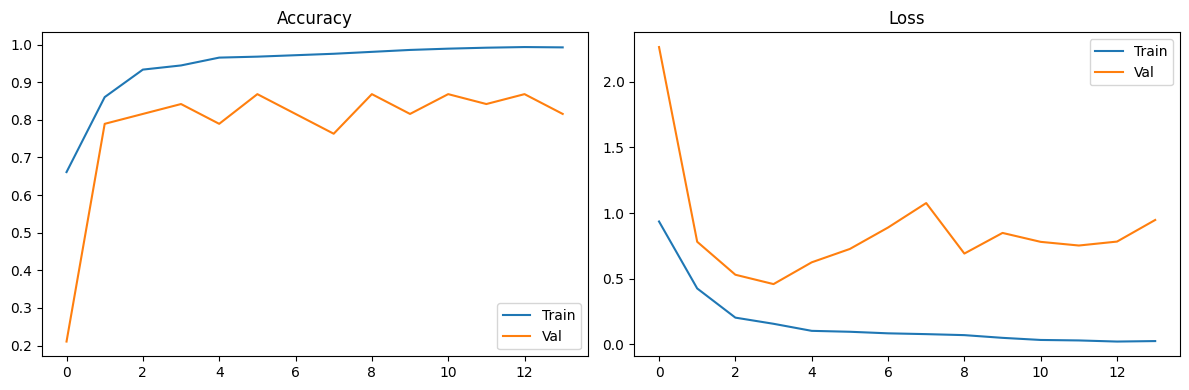

In [15]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss')
axes[1].legend()
plt.tight_layout()
plt.show()